<a href="https://colab.research.google.com/github/CHGROSJEAN/2024_MLEES/blob/main/Projet/Projet_Charlotte_Grosjean_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import libraries and data


Frist step, simple GMM for 2 stations : Grand-Vennes and Riand-Pré.

In [10]:
# Import
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import os
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid




Download data sets

In [3]:
# Reading the Excel files
grandvennes = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/GrandVennes.xlsx")
riandpre = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/RiandPre.xlsx")
chandieu = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Chandieu.xlsx")
geopolis = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Geopolis.xlsx")
lexplore = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/LExplore.xlsx")
bethusy = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Bethusy.xlsx")
boisgentils = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/BoisGentils.xlsx")
elysee = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Elysee.xlsx")
pontaise = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Pontaise.xlsx")
rouvraie = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Rouvraie.xlsx")
vclb = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/VersChezLesBlancs.xlsx")




DateTime ajustment

In [4]:
# Ensuring the 'DateTime' the column is of datetime type for both datasets
grandvennes['DateTime'] = pd.to_datetime(grandvennes['DateTime'], dayfirst=True)
riandpre['DateTime'] = pd.to_datetime(riandpre['DateTime'], dayfirst=True)
chandieu['DateTime'] = pd.to_datetime(chandieu['DateTime'], dayfirst=True)
geopolis['DateTime'] = pd.to_datetime(geopolis['DateTime'], dayfirst=True)
lexplore['DateTime'] = pd.to_datetime(lexplore['DateTime'], dayfirst=True)
bethusy['DateTime'] = pd.to_datetime(bethusy['DateTime'], dayfirst=True)
boisgentils['DateTime'] = pd.to_datetime(boisgentils['DateTime'], dayfirst=True)
elysee['DateTime'] = pd.to_datetime(elysee['DateTime'], dayfirst=True)
pontaise['DateTime'] = pd.to_datetime(pontaise['DateTime'], dayfirst=True)
rouvraie['DateTime'] = pd.to_datetime(rouvraie['DateTime'], dayfirst=True)
vclb['DateTime'] = pd.to_datetime(vclb['DateTime'], dayfirst=True)



# Setting the DateTime column as the index for easier time-based operations
grandvennes.set_index('DateTime', inplace=True)
riandpre.set_index('DateTime', inplace=True)
chandieu.set_index('DateTime', inplace=True)
geopolis.set_index('DateTime', inplace=True)
lexplore.set_index('DateTime', inplace=True)
bethusy.set_index('DateTime', inplace=True)
boisgentils.set_index('DateTime', inplace=True)
elysee.set_index('DateTime', inplace=True)
pontaise.set_index('DateTime', inplace=True)
rouvraie.set_index('DateTime', inplace=True)
vclb.set_index('DateTime', inplace=True)

Aligning all station to be merged in 1 dataset

In [5]:
# Round down the DateTime to the previous minute (removes seconds, truncating)
grandvennes.index = grandvennes.index.floor('min')  # rounded to the nearest lower minute
riandpre.index = riandpre.index.floor('min')
bethusy.index = bethusy.index.floor('min')
boisgentils.index = boisgentils.index.floor('min')
chandieu.index = chandieu.index.floor('min')
elysee.index = elysee.index.floor('min')
lexplore.index = lexplore.index.floor('min')
pontaise.index = pontaise.index.floor('min')
rouvraie.index = rouvraie.index.floor('min')
vclb.index = vclb.index.floor('min')
geopolis.index = geopolis.index.floor('min')

# Resample both datasets to ensure they have data every 3 minutes (if necessary)
# Resampling to the closest 3-minute interval and filling missing values with NaN
grandvennes_resampled = grandvennes.resample('3min').mean()
riandpre_resampled = riandpre.resample('3min').mean()
bethusy_resampled = bethusy.resample('3min').mean()
boisgentils_resampled = boisgentils.resample('3min').mean()
chandieu_resampled = chandieu.resample('3min').mean()
elysee_resampled = elysee.resample('3min').mean()
lexplore_resampled = lexplore.resample('3min').mean()
pontaise_resampled = pontaise.resample('3min').mean()
rouvraie_resampled = rouvraie.resample('3min').mean()
vclb_resampled = vclb.resample('3min').mean()
geopolis_resampled = geopolis.resample('3min').mean()


# Align both datasets to the common time period (intersection of their timestamps)
start_time = max(grandvennes_resampled.index.min(), riandpre_resampled.index.min(),bethusy_resampled.index.min(),
                 boisgentils_resampled.index.min(),chandieu_resampled.index.min(),elysee_resampled.index.min(), lexplore_resampled.index.min(),
                 pontaise_resampled.index.min(),rouvraie_resampled.index.min(),vclb_resampled.index.min(),geopolis_resampled.index.min())


end_time = min(grandvennes_resampled.index.max(), riandpre_resampled.index.max(), bethusy_resampled.index.max(),
               boisgentils_resampled.index.max(),chandieu_resampled.index.max(),elysee_resampled.index.max(),lexplore_resampled.index.max(),
               pontaise_resampled.index.max(),rouvraie_resampled.index.max(),vclb_resampled.index.max(),geopolis_resampled.index.max())

grandvennes_aligned = grandvennes_resampled.loc[start_time:end_time]
riandpre_aligned = riandpre_resampled.loc[start_time:end_time]
bethusy_aligned = bethusy_resampled.loc[start_time:end_time]
boisgentils_aligned = boisgentils_resampled.loc[start_time:end_time]
chandieu_aligned = chandieu_resampled.loc[start_time:end_time]
elysee_aligned = elysee_resampled.loc[start_time:end_time]
lexplore_aligned = lexplore_resampled.loc[start_time:end_time]
pontaise_aligned = pontaise_resampled.loc[start_time:end_time]
rouvraie_aligned = rouvraie_resampled.loc[start_time:end_time]
vclb_aligned = vclb_resampled.loc[start_time:end_time]
geopolis_aligned = geopolis_resampled.loc[start_time:end_time]

# Drop rows with missing values from both datasets
grandvennes_aligned = grandvennes_aligned.dropna()
riandpre_aligned = riandpre_aligned.dropna()
bethusy_aligned = bethusy_aligned.dropna()
boisgentils_aligned = boisgentils_aligned.dropna()
chandieu_aligned = chandieu_aligned.dropna()
elysee_aligned = elysee_aligned.dropna()
lexplore_aligned = lexplore_aligned.dropna()
pontaise_aligned = pontaise_aligned.dropna()
rouvraie_aligned = rouvraie_aligned.dropna()
vclb_aligned = vclb_aligned.dropna()
geopolis_aligned = geopolis_aligned.dropna()


Merging all stations datasets in 1 dataset

In [6]:
# Merge the datasets on the 'DateTime' index
combined_data = pd.concat(
    [
        grandvennes_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Grandvennes'}),
        riandpre_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Riandpre'}),
        bethusy_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Bethusy'}),
        boisgentils_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Boisgentils'}),
        chandieu_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Chandieu'}),
        elysee_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Elysee'}),
        lexplore_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Lexplore'}),
        pontaise_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Pontaise'}),
        rouvraie_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Rouvraie'}),
        vclb_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_VCLB'}),
        geopolis_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Geopolis'})
    ],
    axis=1,
    join='inner'  # Ensures alignment on shared indices only
)

# Display the first few rows of the combined data
print("Combined Precipitation Data:")
print(combined_data.head())
print(combined_data.shape)



Combined Precipitation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0                        0.0   
2023-01-19 14:

# Dataset split

Standardize the data

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_data)

Split the dataset

Only in training and test sets because we are going to use Cross-Validation to tune the Hyperparameter

In [8]:
# Calculate the index for the splits
train_size = int(0.80 * len(X_scaled))  # 85% for training
test_size = len(combined_data) - train_size  # 15% for testing

# Split the data sequentially
train_data = combined_data[:train_size]
test_data = combined_data[train_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())

Training set size: 45699
Test set size: 11425

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0            

In [9]:
# Extract X for each dataset
# For training data
X_train = train_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre', 'Precipitation_Bethusy', 'Precipitation_Boisgentils', 'Precipitation_Chandieu', 'Precipitation_Elysee', 'Precipitation_Lexplore', 'Precipitation_Pontaise', 'Precipitation_Rouvraie', 'Precipitation_VCLB', 'Precipitation_Geopolis']]  # Features (precipitation from both stations)

# For test data
X_test = test_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre', 'Precipitation_Bethusy', 'Precipitation_Boisgentils', 'Precipitation_Chandieu', 'Precipitation_Elysee', 'Precipitation_Lexplore', 'Precipitation_Pontaise', 'Precipitation_Rouvraie', 'Precipitation_VCLB', 'Precipitation_Geopolis']]  # Features (precipitation from both stations)

# Display the first few rows of the extracted data
print("X_train:")
print(X_train.head())

print("\nX_test:")
print(X_test.head())


X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0                        0.0   
2023-01-19 14:15:00               

# Valid

In [ ]:
# Calculate the index for the splits
train_size = int(0.8 * len(X_train_valid))  # 85% for training
Valid_size = len(X_train_valid) - train_size  # 15% for validation

# Split the data sequentially
X_train = X_train_valid[:train_size]
X_valid = X_train_valid[train_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(X_train)}")
print(f"Valid set size: {len(X_valid)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(X_train.head())

print("\nValid Data:")
print(X_valid.head())

Training set size: 38844
Valid set size: 9711

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0            

# Basic Model Initialization

**Cross-Validation with Hyperparameter Tuning**

In [ ]:
svm_test = OneClassSVM(kernel='rbf', nu=0.05, gamma=0.1)
svm_test.fit(scaler.transform(X_train))

OneClassSVM(gamma=0.1, nu=0.05)

In [ ]:
svm_train_predict = svm_test.predict(scaler.transform(X_train))

In [ ]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (svm_train_predict == -1).mean()
print(f"Fraction of train data classified as outliers: {fraction_outliers:.2%}")


Fraction of train data classified as outliers: 4.98%


In [ ]:
# Convert predictions to cluster labels (e.g., map -1 to 0 for clarity)
cluster_labels = (svm_train_predict == 1).astype(int)  # Inliers as 1, Outliers as 0

# Compute Silhouette Score using transformed data
score = silhouette_score(scaler.transform(X_train), cluster_labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.9055112345227462


In [ ]:
svm_valid_predict = svm_test.predict(scaler.transform(X_valid))

In [ ]:
scorer.__call__

<bound method _BaseScorer.__call__ of make_scorer(fraction_outliers, greater_is_better=False, response_method='predict')>

In [ ]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (svm_valid_predict == -1).mean()
print(f"Fraction of train data classified as outliers: {fraction_outliers:.2%}")

Fraction of train data classified as outliers: 2.17%


In [ ]:
# Convert predictions to cluster labels (e.g., map -1 to 0 for clarity)
cluster_labels_valid = (svm_valid_predict == 1).astype(int)  # Inliers as 1, Outliers as 0

# Compute Silhouette Score using transformed data
score_valid = silhouette_score(scaler.transform(X_valid), cluster_labels_valid)
print(f"Silhouette Score: {score_valid}")

Silhouette Score: 0.9517780235282819


In [ ]:
svm_test_predict = svm_test.predict(scaler.transform(X_test))

In [ ]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (svm_test_predict == -1).mean()
print(f"Fraction of train data classified as outliers: {fraction_outliers:.2%}")

Fraction of train data classified as outliers: 24.72%


In [ ]:
# Convert predictions to cluster labels (e.g., map -1 to 0 for clarity)
cluster_labels_test = (svm_test_predict == 1).astype(int)  # Inliers as 1, Outliers as 0

# Compute Silhouette Score using transformed data
score_test = silhouette_score(scaler.transform(X_test), cluster_labels_test)
print(f"Silhouette Score: {score_test}")

Silhouette Score: 0.6396710934646661


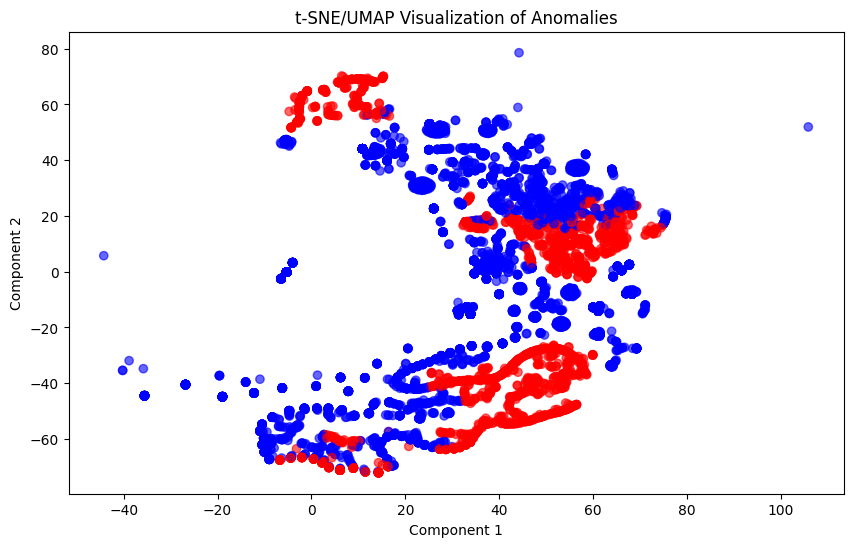

In [ ]:
# Transform data into a lower-dimensional space
# Option 1: t-SNE
embedded_data = TSNE(n_components=2, random_state=42).fit_transform(scaler.transform(X_train))



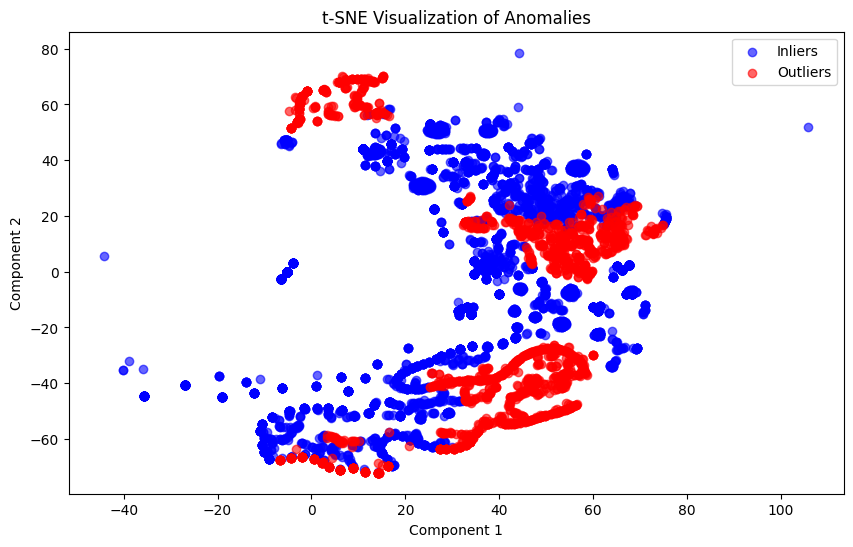

In [ ]:
# Map predictions to colors: inliers (1) vs outliers (-1)
colors = ['red' if label == -1 else 'blue' for label in svm_train_predict]

# Separate inliers and outliers for visualization
inliers = embedded_data[svm_train_predict == 1]
outliers = embedded_data[svm_train_predict == -1]

# Plot with legend
plt.figure(figsize=(10, 6))
plt.scatter(inliers[:, 0], inliers[:, 1], c='blue', alpha=0.6, label='Inliers')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', alpha=0.6, label='Outliers')
plt.title("t-SNE Visualization of Anomalies")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='best')  # Automatically position the legend

# Save the figure as a PDF
output_path = "t-SNE Visualization of Anomalies_1.pdf"
plt.savefig(output_path, format='pdf')

plt.show()

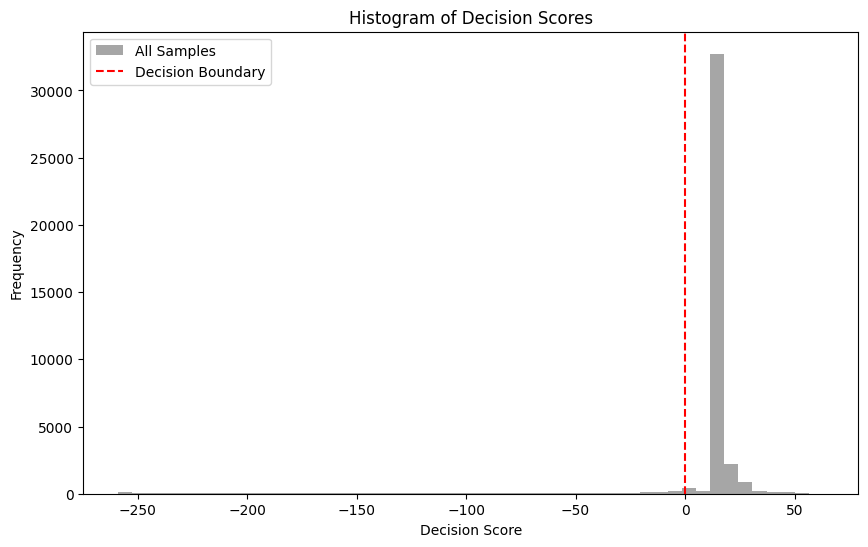

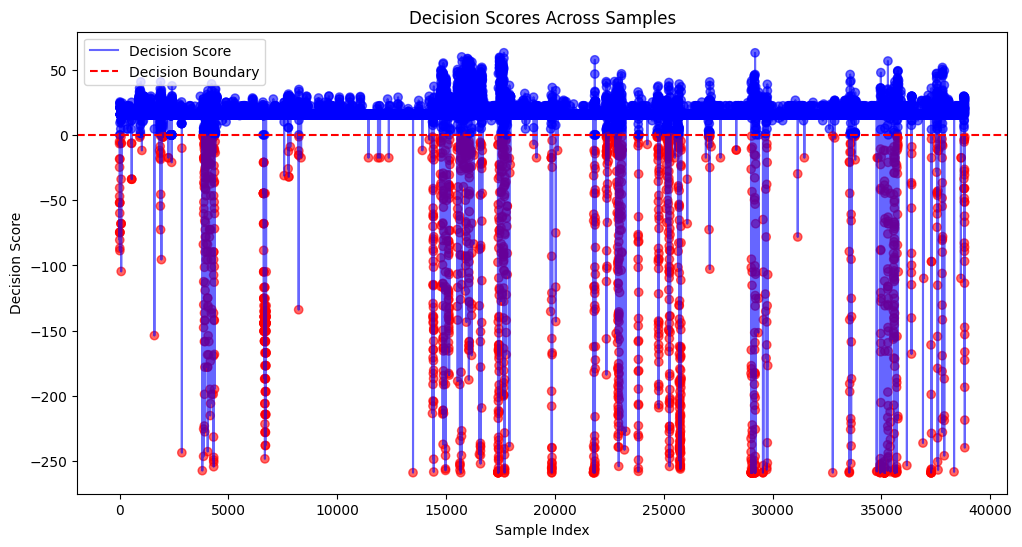

In [ ]:
decision_scores = svm_test.decision_function(scaler.transform(X_train))

# Histogram of decision scores
plt.figure(figsize=(10, 6))
plt.hist(decision_scores, bins=50, color='gray', alpha=0.7, label='All Samples')
plt.axvline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title("Histogram of Decision Scores")
plt.xlabel("Decision Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Line plot (if data has temporal context, e.g., time-series)
plt.figure(figsize=(12, 6))
plt.plot(decision_scores, label='Decision Score', color='blue', alpha=0.6)
plt.scatter(range(len(svm_train_predict)), decision_scores, c=['red' if label == -1 else 'blue' for label in svm_train_predict], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title("Decision Scores Across Samples")
plt.xlabel("Sample Index")
plt.ylabel("Decision Score")
plt.legend()

# Save the figure as a PDF
output_path = "Visualizing Decision Scores.pdf"
plt.savefig(output_path, format='pdf')

plt.show()


# Cross validation

In [12]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(X_train_scaled.head())


                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                  -0.043158                1.658626   
2023-01-19 14:06:00                  -0.043158                1.658626   
2023-01-19 14:09:00                  -0.043158                0.614463   
2023-01-19 14:12:00                  -0.043158                0.266408   
2023-01-19 14:15:00                  -0.043158               -0.081646   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00              -0.017315                  -0.057458   
2023-01-19 14:06:00              -0.017315                  -0.057458   
2023-01-19 14:09:00              -0.017315                  -0.057458   
2023-01-19 14:12:00              -0.017315                  -0.057458   
2023-01-19 14:15:00              -0.017315 

In [18]:
# Stability metric function (modify to return negative score for minimization)
def evaluate_model_stability(X_train_scaled, model_params, n_splits=5):
    scores = []
    for i in range(n_splits):
        # Random split
        idx = np.random.choice(len(X_train_scaled), size=len(X_train_scaled) // 2, replace=False)
        mask = np.zeros(len(X_train_scaled), dtype=bool)
        mask[idx] = True

        X_train_2 = X_train_scaled[mask]
        X_test_2 = X_train_scaled[~mask]  # Complement of mask

        # Train model
        model = OneClassSVM(**model_params)
        model.fit(X_train_2)

        # Compute average distance from decision boundary on the test set
        distances = model.decision_function(X_test_2)
        scores.append(np.var(distances))  # Variance as stability metric

    return -np.mean(scores)  # Return negative to minimize variance

# Create custom scoring function
def stability_scorer(X_train_scaled, model):
    # Use the same parameter grid logic inside GridSearchCV
    return evaluate_model_stability(X_train_scaled, model.get_params())

# Define the parameter grid (example)
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'nu': [0.05, 0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto'],
}

# Perform Grid Search with cross-validation using the stability scorer
grid_search = GridSearchCV(
    estimator=OneClassSVM(),
    param_grid=param_grid,
    scoring=lambda est, X: stability_scorer(X, est),
    cv=3,  # 3-fold cross-validation
    verbose=1
)

# Assuming X_train_scaled is your preprocessed training data
grid_search.fit(X_train_scaled)

# Best hyperparameters
print("Best Params:", grid_search.best_params_)
print("Best Stability Score (Negative Variance):", grid_search.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'gamma': 0.01, 'kernel': 'linear', 'nu': 0.01}
Best Stability Score (Negative Variance): -2.9412075882566005e-09


In [24]:
# Retrieve the best model from GridSearchCV
SVM = OneClassSVM(kernel='linear', nu=0.05, gamma='auto')

In [25]:
#Train the best model on the full training dataset
SVM.fit(X_train_scaled)

OneClassSVM(gamma='auto', kernel='linear', nu=0.05)

In [26]:
train_predictions = SVM.predict(X_train_scaled)

In [27]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (train_predictions == -1).mean()
print(f"Fraction of train data classified as outliers: {fraction_outliers:.2%}")


Fraction of train data classified as outliers: 0.61%


In [28]:
# Convert predictions to cluster labels (e.g., map -1 to 0 for clarity)
cluster_labels_2 = (train_predictions == 1).astype(int)  # Inliers as 1, Outliers as 0

# Compute Silhouette Score using transformed data
score = silhouette_score(X_train_scaled, cluster_labels_2)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.9511074907941042


In [29]:
# Evaluate the model on the test data
# Predict anomalies (-1 for anomalies, 1 for normal)
test_predictions = SVM.predict(X_test_scaled)

In [30]:
# Calculate the fraction of points classified as anomalies in the test set
fraction_outliers = (test_predictions == -1).mean()
print(f"Fraction of test data classified as outliers: {fraction_outliers:.2%}")


Fraction of test data classified as outliers: 0.05%


In [31]:
# Convert predictions to cluster labels (e.g., map -1 to 0 for clarity)
cluster_labels_test2 = (test_predictions == 1).astype(int)  # Inliers as 1, Outliers as 0

# Compute Silhouette Score using transformed data
score = silhouette_score(X_test_scaled, cluster_labels_test2)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.8779664883146929


# Visualization

In [34]:
# Transform data into a lower-dimensional space
# Option 1: t-SNE
embedded_data = TSNE(n_components=2, random_state=42).fit_transform(scaler.transform(X_train))




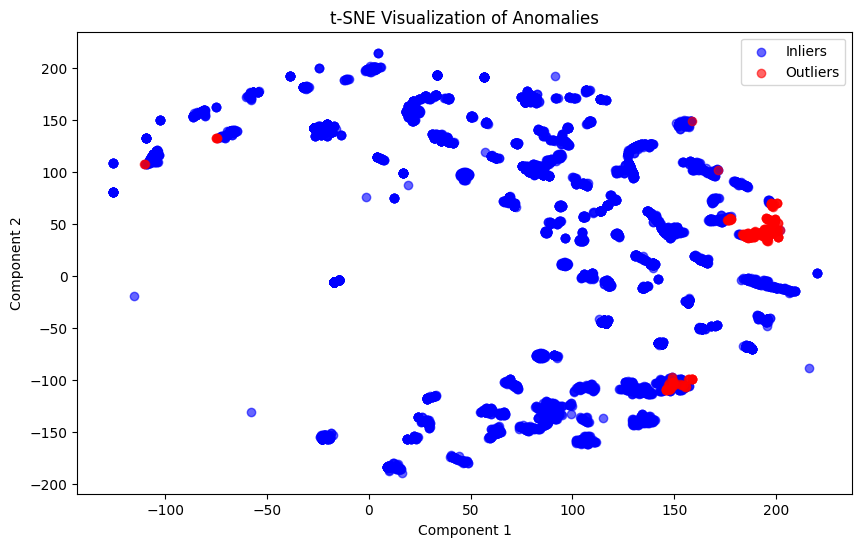

In [35]:
# Map predictions to colors: inliers (1) vs outliers (-1)
colors = ['red' if label == -1 else 'blue' for label in train_predictions]

# Separate inliers and outliers for visualization
inliers = embedded_data[train_predictions == 1]
outliers = embedded_data[train_predictions == -1]

# Plot with legend
plt.figure(figsize=(10, 6))
plt.scatter(inliers[:, 0], inliers[:, 1], c='blue', alpha=0.6, label='Inliers')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', alpha=0.6, label='Outliers')
plt.title("t-SNE Visualization of Anomalies")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='best')  # Automatically position the legend

# Save the figure as a PDF
output_path = "t-SNE Visualization of Anomalies_1.pdf"
plt.savefig(output_path, format='pdf')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


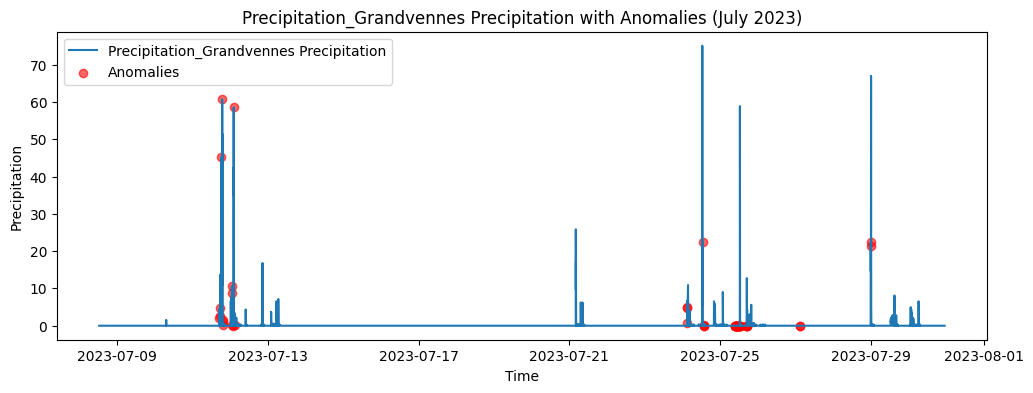

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


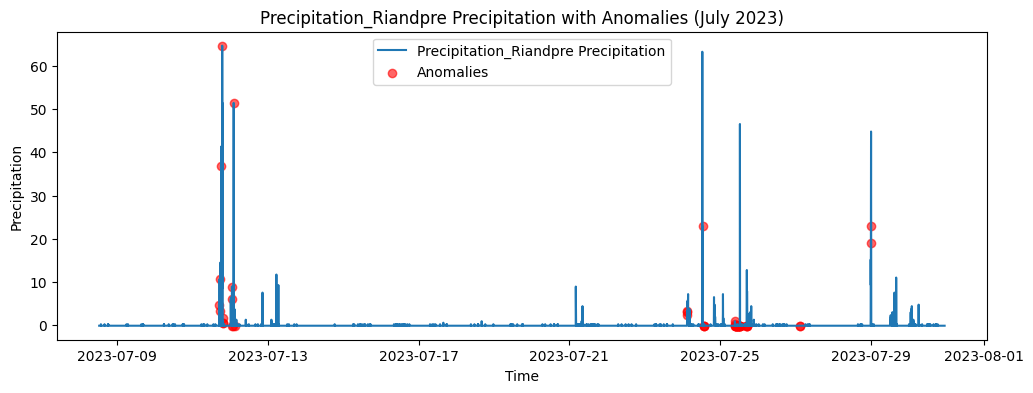

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


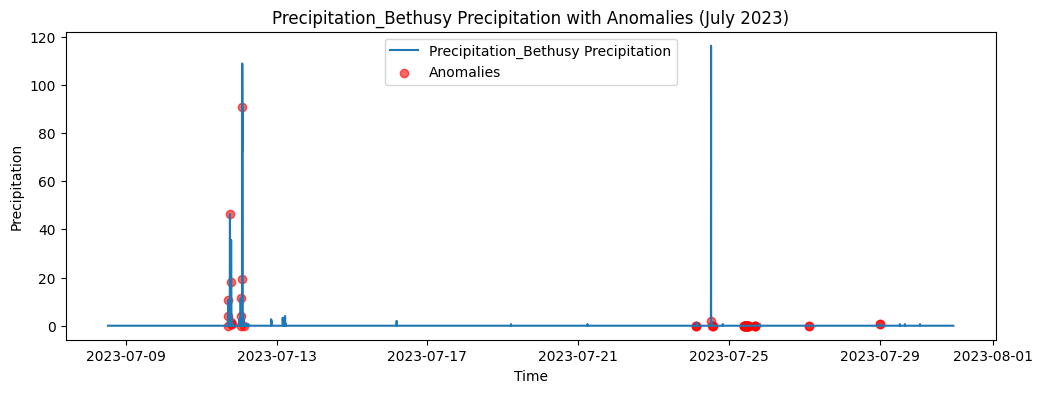

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


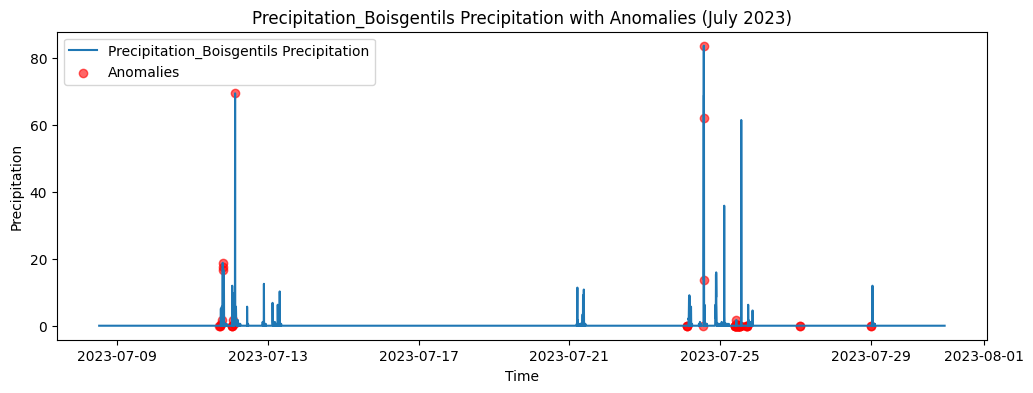

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


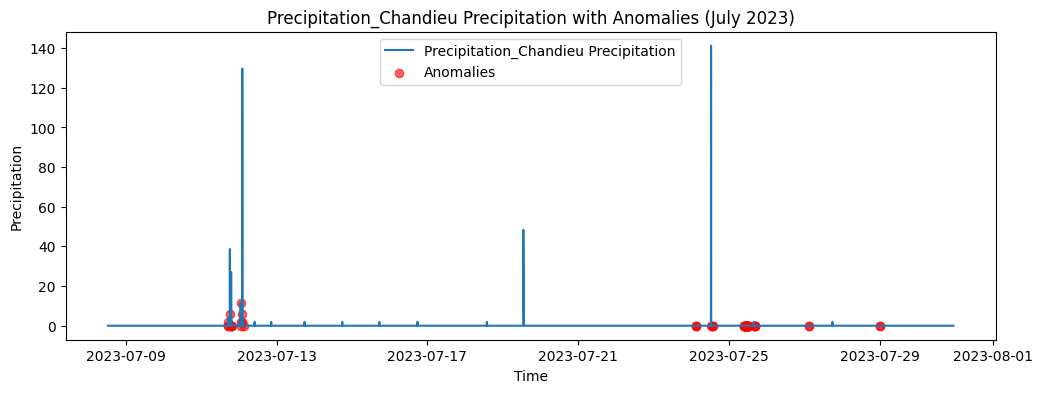

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


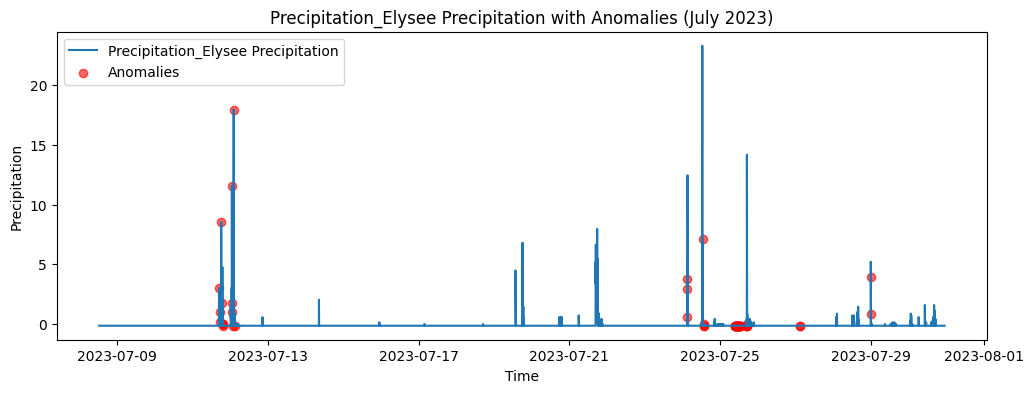

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


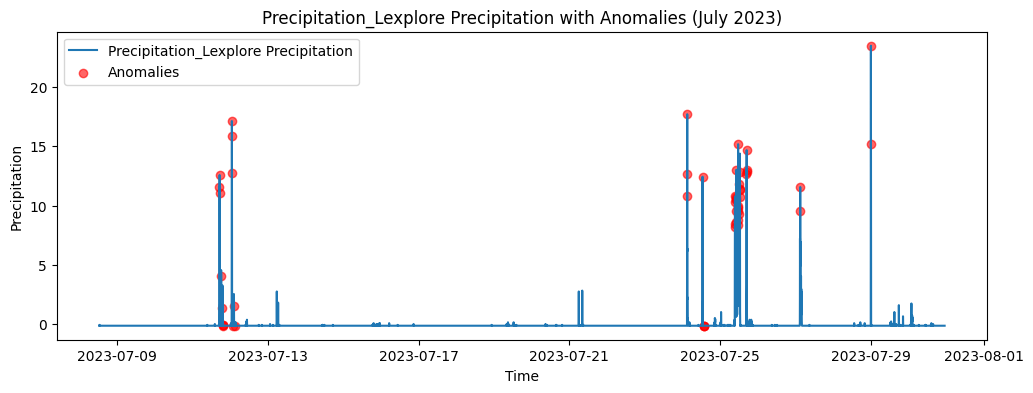

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


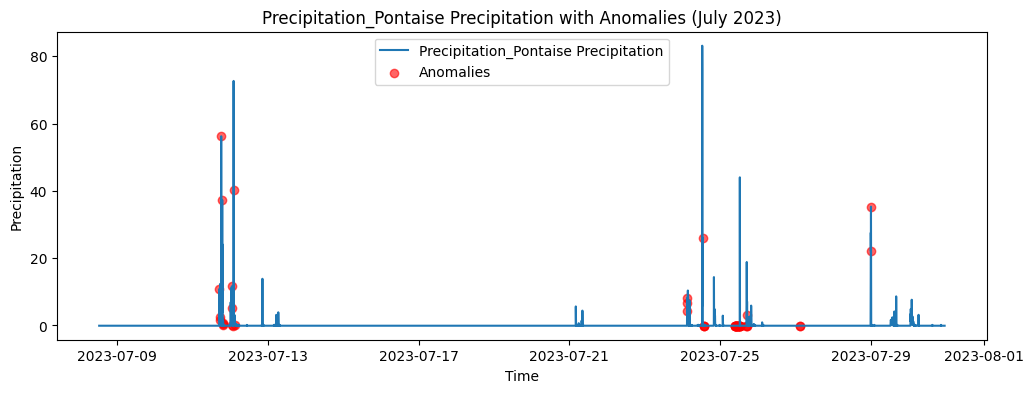

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


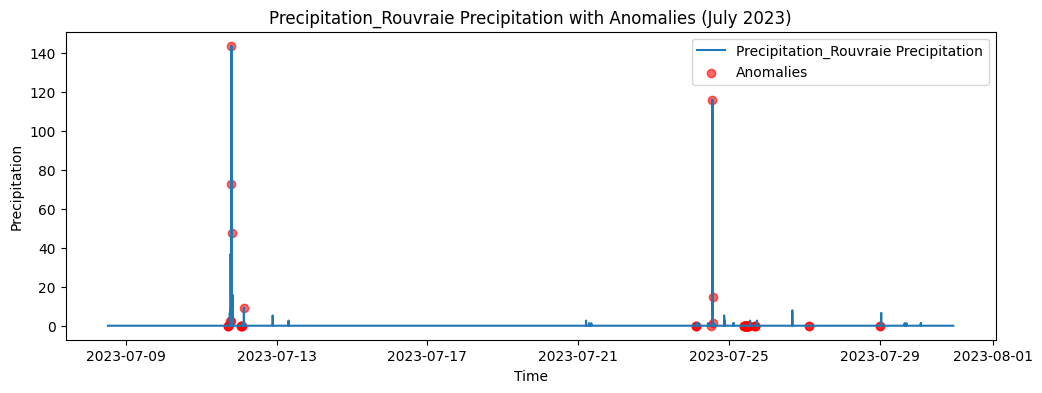

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


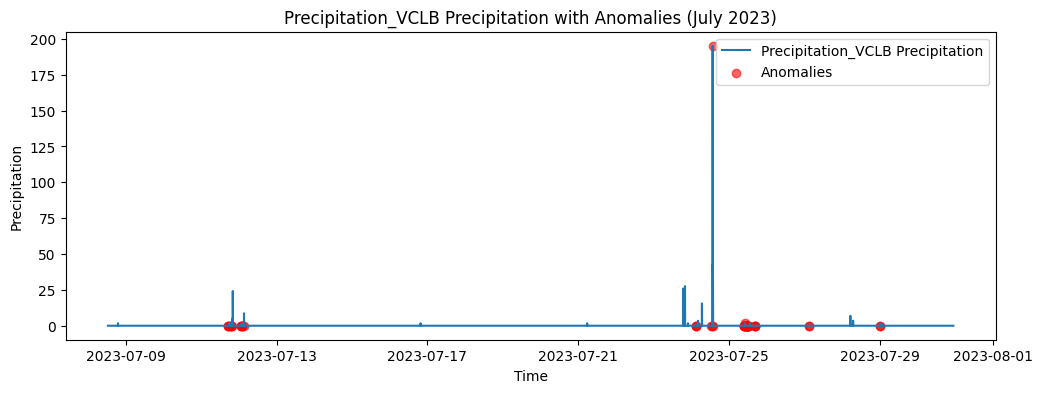

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


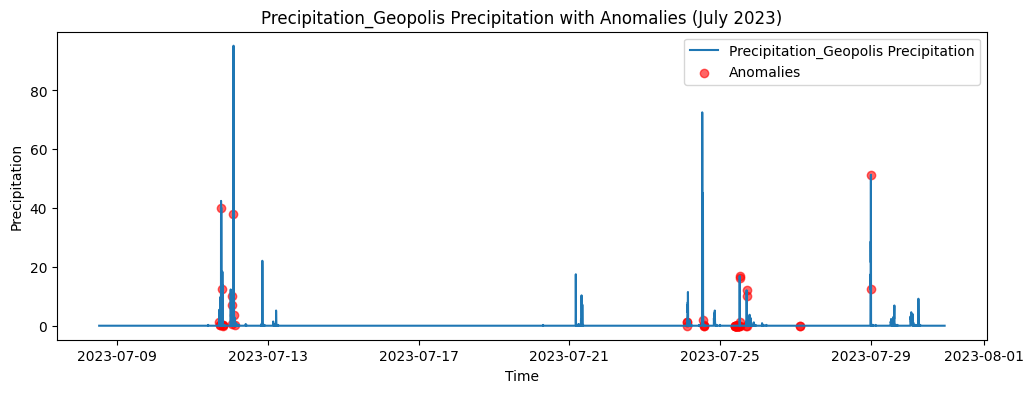

In [41]:
import matplotlib.pyplot as plt

# Define the time period for July 2023
start_date = '2023-07-01 00:00:00'
end_date = '2023-07-30 23:00:00'

# Filter the full dataset for the month of July 2023
july_data = X_train_scaled.loc[start_date:end_date]

# Loop over each station
for station in X_train_scaled.columns:
    # Extract the data for the current station
    station_data = july_data[station]

    # Reshape the entire data to 2D for OneClassSVM
    july_data_reshaped = july_data.values  # This keeps all 11 stations

    # Predict anomalies using OneClassSVM
    predictions = SVM.predict(july_data_reshaped)

    # Anomalies are marked with -1, so find the indexes where prediction is -1
    anomalies = july_data.index[predictions == -1]


    # Create a plot for the current station
    plt.figure(figsize=(12, 4))
    plt.plot(station_data.index, station_data, label=f"{station} Precipitation")
    plt.scatter(anomalies, station_data.loc[anomalies], color='red', label="Anomalies", alpha=0.6)

    # Add labels and title
    plt.title(f"{station} Precipitation with Anomalies (July 2023)")
    plt.xlabel("Time")
    plt.ylabel("Precipitation")
    plt.legend()

    # Save the figure as a PDF
    output_path_2 = "Precipitation_with_Anomalies_July_2023.pdf"
    plt.savefig(output_path_2, format='pdf')

    # Display the plot
    plt.show()